In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split


import numpy as np
from numpy.random import rand
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from random import randrange
import time
from scipy.stats import pearsonr

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
# Random seed for reproducibility
seed = 61

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# **Data Loading & Analysis**

In [3]:
x_train = np.load("/kaggle/input/homework2timeseries/x_train.npy")
y_train = np.load("/kaggle/input/homework2timeseries/y_train.npy")

In [4]:
print("X_train Shape:", x_train.shape)
print("Y_train Shape:", y_train.shape)

X_train Shape: (2429, 36, 6)
Y_train Shape: (2429,)


In [5]:
np.shape(x_train[0:][3])

(36, 6)

In [6]:
#we used it only for 1DCNN models
def standardize(x_train):
    t=[]
    for i in range(np.shape(x_train)[2]):
        t.append(x_train[:,:,i] - x_train[:,:,i].mean() / x_train.std())
    temp= np.asarray(t)
    temp2=temp.reshape((np.shape(x_train)[2], np.shape(x_train)[0]*np.shape(x_train)[1]))
    temp2_trans = temp2.transpose()
    x_train_normalized = temp2_trans.reshape(np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2])
    return x_train_normalized



In [7]:
#we did not use it due to worse perfomance in models
'''def normalize(x_train):
    for i in range(36):
        X_min = x_train[0:][i].min()
        X_max = x_train[0:][i].max()
    
        x_train[0:][i] = (x_train[0:][i]-X_min)/(X_max-X_min)
    return x_train
    #X_test[0:][i] = (X_test[0:][i]-X_min)/(X_max-X_min)'''

'def normalize(x_train):\n    for i in range(36):\n        X_min = x_train[0:][i].min()\n        X_max = x_train[0:][i].max()\n    \n        x_train[0:][i] = (x_train[0:][i]-X_min)/(X_max-X_min)\n    return x_train\n    #X_test[0:][i] = (X_test[0:][i]-X_min)/(X_max-X_min)'

In [8]:
def corr(x_train):
    r=[]
    x_train_feature_0=np.squeeze(x_train[:,:, :1], axis=-1)
    x_train_feature_1=np.squeeze(x_train[:,:,1:2], axis=-1)
    x_train_feature_2=np.squeeze(x_train[:,:,2:3], axis=-1)
    x_train_feature_3=np.squeeze(x_train[:,:,3:4], axis=-1)
    x_train_feature_4=np.squeeze(x_train[:,:,4:5], axis=-1)
    x_train_feature_5=np.squeeze(x_train[:,:,5:6], axis=-1) 
    
    x_train_feature_0_vec = x_train_feature_0.flatten()
    x_train_feature_1_vec = x_train_feature_1.flatten()
    x_train_feature_2_vec = x_train_feature_2.flatten()
    x_train_feature_3_vec = x_train_feature_3.flatten()
    x_train_feature_4_vec = x_train_feature_4.flatten()
    x_train_feature_5_vec = x_train_feature_5.flatten()
    feature_list =[x_train_feature_0_vec, x_train_feature_1_vec, x_train_feature_2_vec, x_train_feature_3_vec, x_train_feature_4_vec, x_train_feature_5_vec]
    
    for i in range(len(feature_list)):
        for j in range(i+1, len(feature_list)):
            r.append(pearsonr(feature_list[i], feature_list[j]))

    return r 

In [9]:
corr(x_train)

[(0.2707943238924376, 0.0),
 (0.30149205289622216, 0.0),
 (0.2932833550172697, 0.0),
 (0.2594447324055683, 0.0),
 (0.2535044001493484, 0.0),
 (0.47489510735539453, 0.0),
 (0.43893229947526896, 0.0),
 (0.3568073015573965, 0.0),
 (0.3273887789489329, 0.0),
 (0.6122040260924503, 0.0),
 (0.5159915391192499, 0.0),
 (0.4592274526605268, 0.0),
 (0.5648467101086626, 0.0),
 (0.49082509817017683, 0.0),
 (0.7002739552833777, 0.0)]

In [10]:
'''we did not use feature 0 in LSTM models at first. 
However, since submission accuracy got worse, we decided to use it at last'''
#x_train = x_train[0:, :, 1:6]

'we did not use feature 0 in LSTM models at first. \nHowever, since submission accuracy got worse, we decided to use it at last'

In [11]:
X_train, X_test, y_train, y_test = train_test_split(standardize(x_train), y_train, test_size=0.1, random_state=seed, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed, shuffle=True)

In [12]:
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
y_val = tfk.utils.to_categorical(y_val)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1967, 36, 6), (1967, 12), (243, 36, 6), (243, 12), (219, 36, 6), (219, 12))

In [13]:
#Another way of data normalization that we did not use it at last
'''
for i in range(36):
    X_min = X_train[0:][i].min()
    X_max = X_train[0:][i].max()
    
    X_train[0:][i] = (X_train[0:][i]-X_min)/(X_max-X_min)
    X_test[0:][i] = (X_test[0:][i]-X_min)/(X_max-X_min)
'''

'\nfor i in range(36):\n    X_min = X_train[0:][i].min()\n    X_max = X_train[0:][i].max()\n    \n    X_train[0:][i] = (X_train[0:][i]-X_min)/(X_max-X_min)\n    X_test[0:][i] = (X_test[0:][i]-X_min)/(X_max-X_min)\n'

In [14]:
input_shape = X_train.shape[1:]

classes = y_train.shape[-1]
batch_size = 16
epochs = 50

In [15]:
input_shape

(36, 6)

# **Designing & Training Models**

In [16]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    lstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(lstm)
    Skip_LSTM = tfkl.LSTM(256, return_sequences=True)(input_layer)
    #Skip_GRU = tfkl.GRU(512, return_sequences=True)(Skip_GRU)
    #Skip_LSTM = tfkl.LSTM(256, return_sequences=False)(input_layer)

    lstm = tfkl.GlobalMaxPooling1D()(lstm)
    Skip_LSTM = tfkl.GlobalMaxPooling1D()(Skip_LSTM)
    #Skip_LSTM = tfkl.GlobalMaxPooling1D()(Skip_LSTM)

    dropout = tfkl.Dropout(.1, seed=seed)(lstm)
    Skip_LSTM = tfkl.Dropout(.1)(Skip_LSTM)
    #Skip_LSTM = tfkl.Dropout(.3)(Skip_LSTM)

    flatt=tfkl.concatenate([dropout,Skip_LSTM])
    # Classifier
    
    #classifier = tfkl.Dense(128, activation='relu')(flatt)
    classifier = tfkl.Dense(256, activation='relu')(flatt)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [17]:
model_LSTM = build_LSTM_classifier(input_shape, classes)
model_LSTM.summary()

2022-12-23 14:07:18.161543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 14:07:18.247823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 14:07:18.248906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 14:07:18.251101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 36, 512)      538624      Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 36, 1024)     4198400     bidirectional[0][0]              
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 36, 256)      269312      Input[0][0]                      
______________________________________________________________________________________________

In [18]:
# Train the model
history_LSTM = model_LSTM.fit(
    [X_train],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001),
        tfk.callbacks.ModelCheckpoint('LSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    ]
).history

Epoch 1/50


2022-12-23 14:07:22.173575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-23 14:07:28.477183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


111/111 [==============================] - 12s 39ms/step - loss: 1.4266 - accuracy: 0.5237 - val_loss: 1.1185 - val_accuracy: 0.6294
Epoch 2/50
111/111 [==============================] - 3s 24ms/step - loss: 1.0267 - accuracy: 0.6508 - val_loss: 0.9159 - val_accuracy: 0.6853
Epoch 3/50
111/111 [==============================] - 3s 25ms/step - loss: 0.8148 - accuracy: 0.7232 - val_loss: 1.0544 - val_accuracy: 0.6497
Epoch 4/50
111/111 [==============================] - 3s 25ms/step - loss: 0.6661 - accuracy: 0.7559 - val_loss: 0.9306 - val_accuracy: 0.6853
Epoch 5/50
111/111 [==============================] - 3s 25ms/step - loss: 0.5508 - accuracy: 0.8141 - val_loss: 0.9784 - val_accuracy: 0.6650

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/50
111/111 [==============================] - 3s 24ms/step - loss: 0.3143 - accuracy: 0.8966 - val_loss: 0.9519 - val_accuracy: 0.6904
Epoch 7/50
111/111 [==============================] - 3s 25ms/step - lo

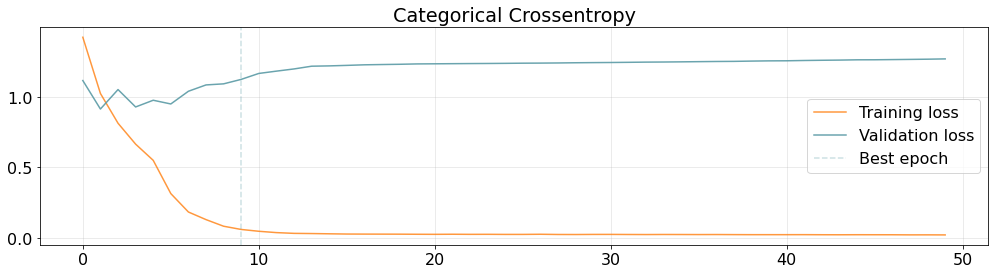

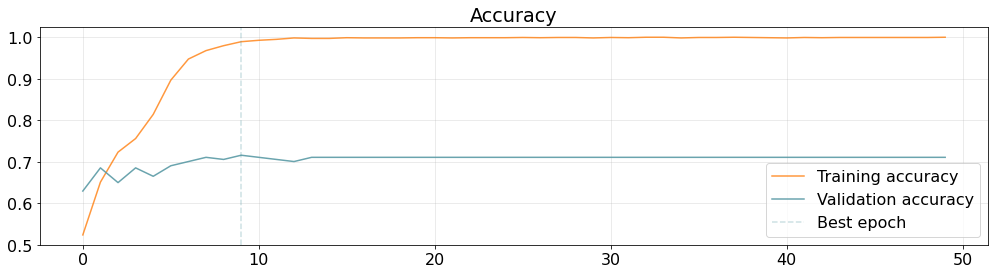

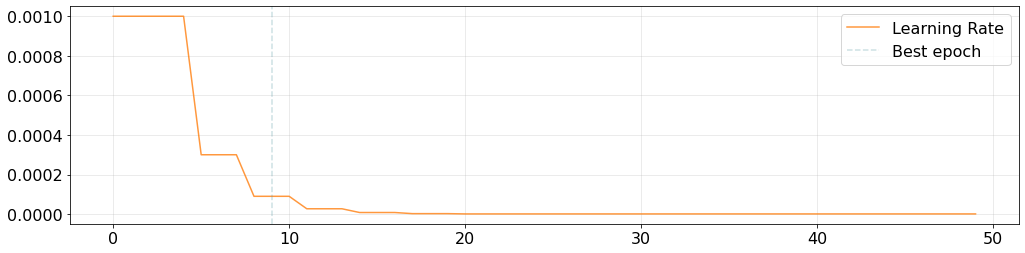

In [19]:
best_epoch = np.argmax(history_LSTM['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history_LSTM['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_LSTM['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_LSTM['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_LSTM['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_LSTM['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [20]:
#model_LSTM.save('LSTM')

In [21]:
# Predict the test set with the LSTM
predictions_LSTM = model_LSTM.predict([X_test])
predictions_LSTM.shape

(243, 12)

In [22]:
# Compute the confusion matrix
cm_LSTM = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_LSTM, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_LSTM, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_LSTM, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_LSTM, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_LSTM, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print("Confusion Matrix:")
print(cm_LSTM)

Accuracy: 0.7037
Precision: 0.7447
Recall: 0.6111
F1: 0.6423
Confusion Matrix:
[[ 1  0  0  1  0  0  1  0  0  1  0  1]
 [ 0  9  0  1  0  0  1  0  0  2  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0]
 [ 0  1  0 18  1  1  0  2  0 13  0  0]
 [ 0  0  0  2  1  0  0  0  0  3  0  0]
 [ 0  0  0  2  0  5  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 25  0  0  4  0  0]
 [ 0  0  0  1  0  1  2  2  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  8  0  4  1  2  0 62  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  5]]


In [23]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.GRU(128))(bilstm)
    dropout = tfkl.Dropout(.2, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [24]:
model_BiLSTM = build_BiLSTM_classifier(input_shape, classes)
model_BiLSTM.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 36, 256)           104448    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 435,340
Trainable params: 435,340
Non-trainable params: 0
_______________________________________________________

In [25]:
# Train the model
history_BiLSTM = model_BiLSTM.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001),
        tfk.callbacks.ModelCheckpoint('LSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    ]
).history

Epoch 1/50
111/111 [==============================] - 6s 19ms/step - loss: 1.7535 - accuracy: 0.4164 - val_loss: 1.4862 - val_accuracy: 0.4721
Epoch 2/50
111/111 [==============================] - 1s 10ms/step - loss: 1.2847 - accuracy: 0.5508 - val_loss: 1.3225 - val_accuracy: 0.5533
Epoch 3/50
111/111 [==============================] - 1s 10ms/step - loss: 0.9934 - accuracy: 0.6525 - val_loss: 1.2074 - val_accuracy: 0.5736
Epoch 4/50
111/111 [==============================] - 1s 11ms/step - loss: 0.7526 - accuracy: 0.7373 - val_loss: 1.2449 - val_accuracy: 0.5584
Epoch 5/50
111/111 [==============================] - 1s 11ms/step - loss: 0.5867 - accuracy: 0.8028 - val_loss: 1.1809 - val_accuracy: 0.5939
Epoch 6/50
111/111 [==============================] - 1s 10ms/step - loss: 0.4289 - accuracy: 0.8582 - val_loss: 1.2872 - val_accuracy: 0.5990
Epoch 7/50
111/111 [==============================] - 1s 10ms/step - loss: 0.3095 - accuracy: 0.9062 - val_loss: 1.4435 - val_accuracy: 0.5888

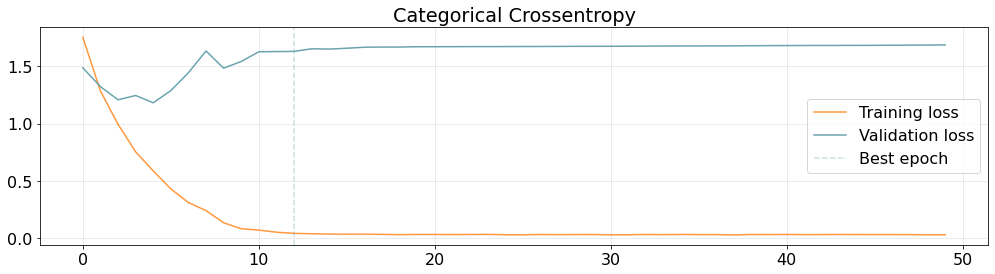

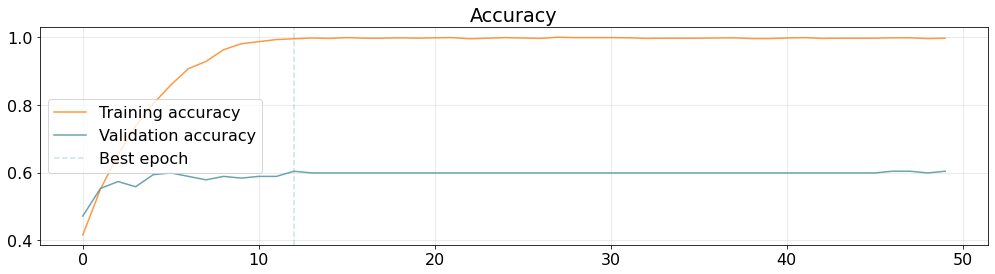

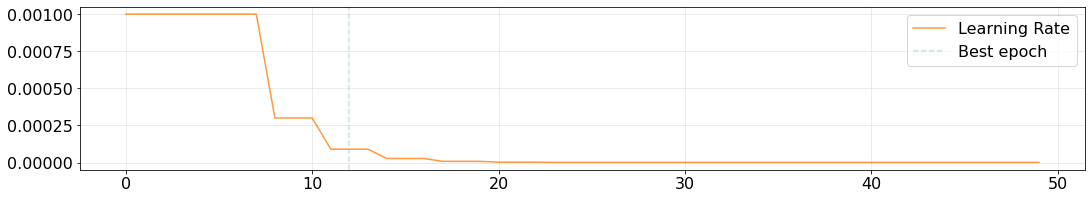

In [26]:
best_epoch = np.argmax(history_BiLSTM['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history_BiLSTM['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_BiLSTM['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_BiLSTM['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_BiLSTM['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history_BiLSTM['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [27]:
# Predict the test set with the BiLSTM
predictions_BiLSTM = model_BiLSTM.predict(X_test)
predictions_BiLSTM.shape

(243, 12)

In [28]:
# Compute the confusion matrix
cm_BiLSTM = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_BiLSTM, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_BiLSTM, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_BiLSTM, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_BiLSTM, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_BiLSTM, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print("Confusion Matrix:")
print(cm_BiLSTM)

Accuracy: 0.6132
Precision: 0.5544
Recall: 0.4823
F1: 0.4901
Confusion Matrix:
[[ 1  0  0  1  0  1  0  0  0  1  0  1]
 [ 0  4  0  1  0  0  0  0  0  6  1  1]
 [ 0  0 19  0  0  0  2  0  0  0  2  0]
 [ 0  0  0 16  1  2  2  0  0 15  0  0]
 [ 0  0  0  2  0  0  0  0  0  4  0  0]
 [ 0  0  0  4  0  2  0  0  0  8  0  0]
 [ 0  0  1  0  0  0 20  0  0  8  0  0]
 [ 0  0  0  2  0  2  1  1  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  1  0]
 [ 1  2  0  3  1  1  3  1  0 64  0  1]
 [ 0  0  4  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  5]]


In [29]:
def build_1DCNN_classifierV1(input_shape, classes):
      # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='sigmoid')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)
    skip_cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    skip_gap = tfkl.GlobalAveragePooling1D()(cnn)
    skip_dropout = tfkl.Dropout(.3, seed=seed)(gap)
    
    #flatt=tfkl.concatenate([gap,skip_gap])
    flatt=tfkl.concatenate([gap,skip_gap,dropout,skip_dropout])
    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(flatt)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [30]:
model_1DCNN_V1 = build_1DCNN_classifierV1(input_shape, classes)
model_1DCNN_V1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 36, 512)      9728        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 512)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 256)      393472      max_pooling1d[0][0]              
______________________________________________________________________________________________

In [31]:
# Train the model
history_1DCNN_V1 = model_1DCNN_V1.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001),
        tfk.callbacks.ModelCheckpoint('1DCNN_V1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    ]
).history

Epoch 1/50
111/111 [==============================] - 6s 6ms/step - loss: 1.8264 - accuracy: 0.4051 - val_loss: 1.5729 - val_accuracy: 0.4670
Epoch 2/50
111/111 [==============================] - 0s 4ms/step - loss: 1.5091 - accuracy: 0.4898 - val_loss: 1.3262 - val_accuracy: 0.5685
Epoch 3/50
111/111 [==============================] - 0s 4ms/step - loss: 1.3504 - accuracy: 0.5277 - val_loss: 1.1839 - val_accuracy: 0.5990
Epoch 4/50
111/111 [==============================] - 0s 4ms/step - loss: 1.2587 - accuracy: 0.5655 - val_loss: 1.1851 - val_accuracy: 0.6142
Epoch 5/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1955 - accuracy: 0.5910 - val_loss: 1.0923 - val_accuracy: 0.6294
Epoch 6/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1639 - accuracy: 0.5938 - val_loss: 1.1318 - val_accuracy: 0.6244
Epoch 7/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1207 - accuracy: 0.5994 - val_loss: 1.0631 - val_accuracy: 0.6041
Epoch 

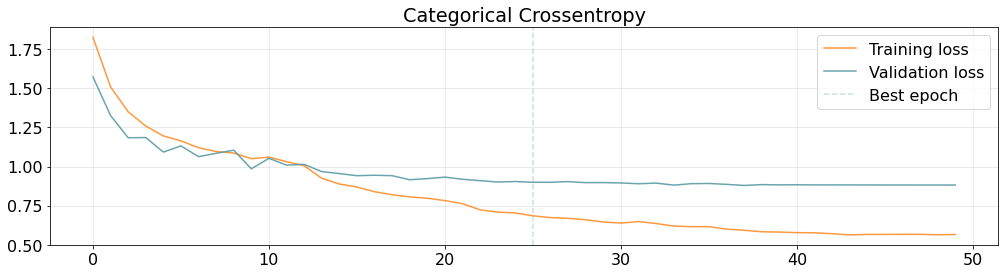

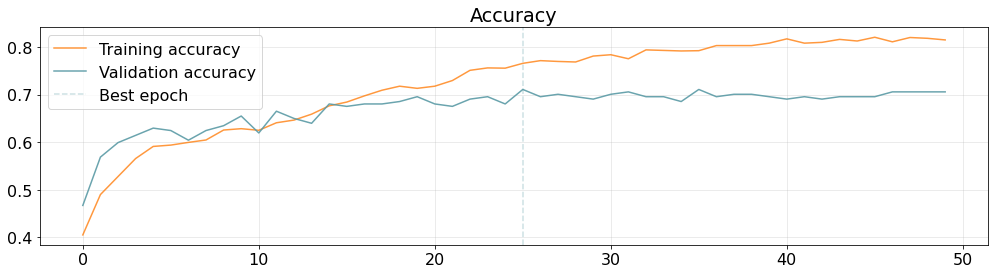

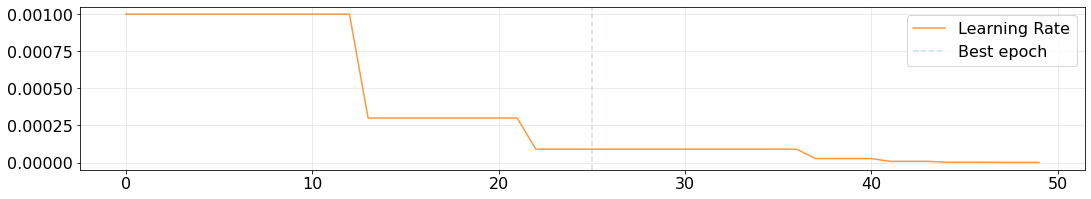

In [32]:
best_epoch = np.argmax(history_1DCNN_V1['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history_1DCNN_V1['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_1DCNN_V1['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_1DCNN_V1['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_1DCNN_V1['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history_1DCNN_V1['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [33]:
# Predict the test set with the 1DCNN
predictions_1DCNN_V1 = model_1DCNN_V1.predict(X_test)
predictions_1DCNN_V1.shape

(243, 12)

In [34]:
# Compute the confusion matrix
cm_1DCNN = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V1, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V1, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V1, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V1, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V1, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

print("Confusion Matrix:")
print(cm_1DCNN)

Accuracy: 0.7037
Precision: 0.7394
Recall: 0.5604
F1: 0.5858
Confusion Matrix:
[[ 1  1  0  0  0  0  0  0  0  2  0  1]
 [ 0  7  0  3  0  0  0  0  0  3  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  3  1  0  0 12  0  0]
 [ 0  0  0  2  0  0  0  0  0  4  0  0]
 [ 0  0  0  3  0  3  1  0  0  7  0  0]
 [ 0  0  0  0  0  0 27  0  0  2  0  0]
 [ 0  0  0  3  0  0  2  1  0  6  0  0]
 [ 0  0  0  0  0  0  1  0 13  0  0  0]
 [ 0  2  0  8  0  0  1  0  0 66  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  4]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
def build_1DCNN_classifierV2(input_shape, classes):
     # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='sigmoid')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.3, seed=seed)(gap)
    #skip_cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    skip_gap = tfkl.GlobalAveragePooling1D()(cnn)
    skip_dropout = tfkl.Dropout(.3, seed=seed)(gap)
    
    #flatt=tfkl.concatenate([gap,skip_gap])
    flatt=tfkl.concatenate([gap,skip_gap,dropout,skip_dropout])
    # Classifier
    classifier = tfkl.Dense(256, activation='relu')(flatt)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [36]:
model_1DCNN_V2 = build_1DCNN_classifierV2(input_shape, classes)
model_1DCNN_V2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 36, 512)      9728        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 18, 512)      0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 18, 256)      393472      max_pooling1d_1[0][0]            
______________________________________________________________________________________________

In [37]:
# Train the model
history_1DCNN_V2 = model_1DCNN_V2.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001),
        tfk.callbacks.ModelCheckpoint('1DCNN_V1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    ]
).history

Epoch 1/50
111/111 [==============================] - 1s 7ms/step - loss: 1.8549 - accuracy: 0.3921 - val_loss: 1.5755 - val_accuracy: 0.4822
Epoch 2/50
111/111 [==============================] - 0s 4ms/step - loss: 1.4951 - accuracy: 0.4927 - val_loss: 1.3169 - val_accuracy: 0.5584
Epoch 3/50
111/111 [==============================] - 0s 4ms/step - loss: 1.3569 - accuracy: 0.5373 - val_loss: 1.2361 - val_accuracy: 0.5685
Epoch 4/50
111/111 [==============================] - 0s 4ms/step - loss: 1.2427 - accuracy: 0.5718 - val_loss: 1.1477 - val_accuracy: 0.6142
Epoch 5/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1941 - accuracy: 0.5881 - val_loss: 1.0857 - val_accuracy: 0.6396
Epoch 6/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1483 - accuracy: 0.5938 - val_loss: 1.1433 - val_accuracy: 0.6244
Epoch 7/50
111/111 [==============================] - 0s 4ms/step - loss: 1.1218 - accuracy: 0.6068 - val_loss: 1.0602 - val_accuracy: 0.6396
Epoch 

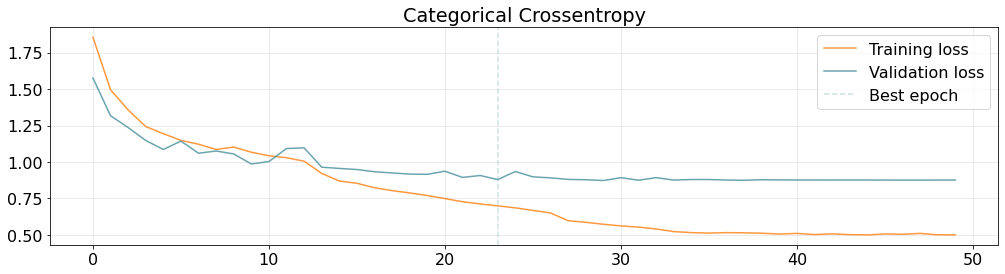

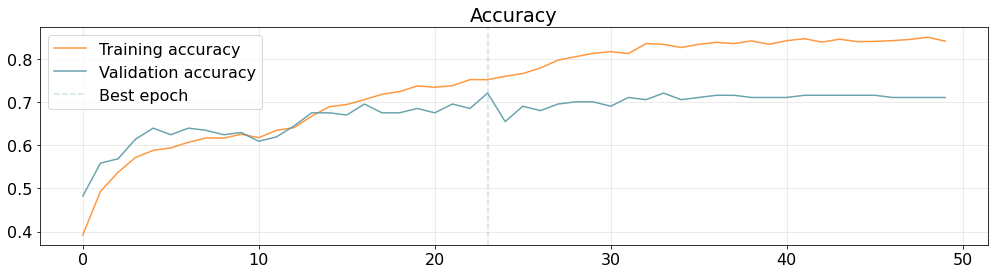

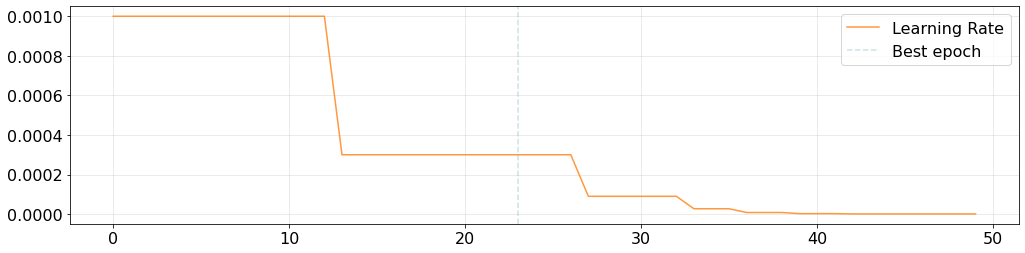

In [38]:
best_epoch = np.argmax(history_1DCNN_V2['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history_1DCNN_V2['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_1DCNN_V2['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_1DCNN_V2['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_1DCNN_V2['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_1DCNN_V2['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [39]:
# Predict the test set with the 1DCNN
predictions_1DCNN_V2 = model_1DCNN_V2.predict(X_test)
predictions_1DCNN_V2.shape

(243, 12)

In [40]:
# Compute the confusion matrix
cm_1DCNN = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V2, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V2, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V2, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V2, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_1DCNN_V2, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

print("Confusion Matrix:")
print(cm_1DCNN)

Accuracy: 0.6996
Precision: 0.6781
Recall: 0.5439
F1: 0.5474
Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  1  3  0  1]
 [ 0  6  0  4  0  0  0  0  0  3  0  0]
 [ 0  0 21  0  0  0  0  0  0  0  2  0]
 [ 0  1  0 21  0  0  1  0  0 13  0  0]
 [ 0  0  0  1  0  0  0  0  0  5  0  0]
 [ 0  0  0  4  0  2  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 27  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  1  0  9  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0]
 [ 0  2  0  6  0  0  2  0  0 67  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  4]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Things we tried but was not Effective**

***1) DataAugmentation***

In [41]:
pip install tsaug

Note: you may need to restart the kernel to use updated packages.


(<Figure size 1152x864 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

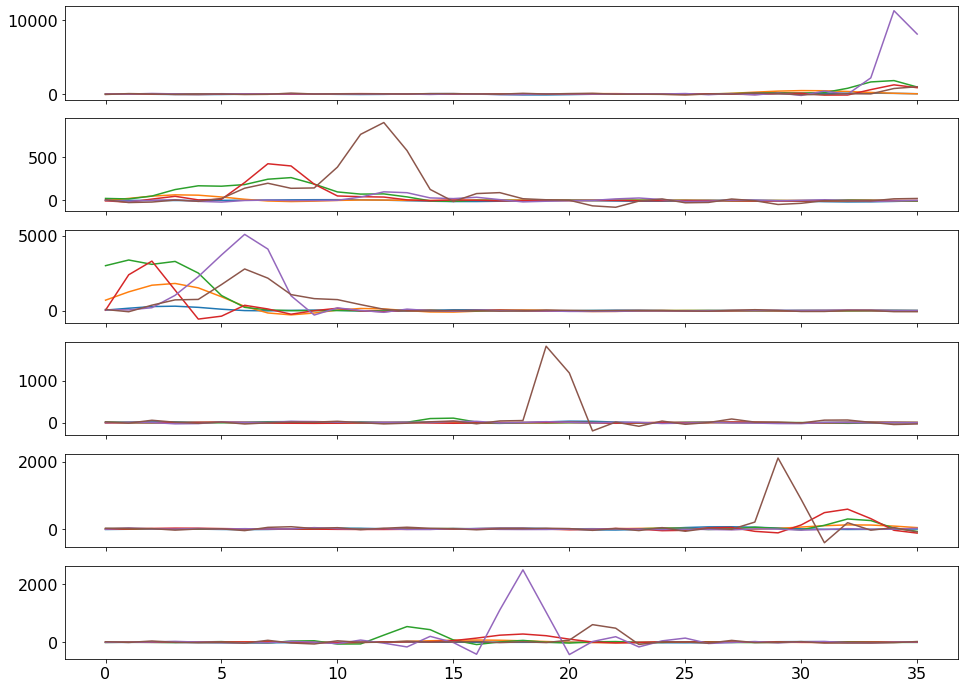

In [42]:
from tsaug.visualization import plot
plot(x_train[0:6,:,:])

In [43]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (
    TimeWarp() * 5  # random time warping 5 times in parallel
     + Crop(size=36)  # random crop subsequences with length 300
     + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     + Drift(max_drift=(0.2, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
 )

(25, 36, 6)

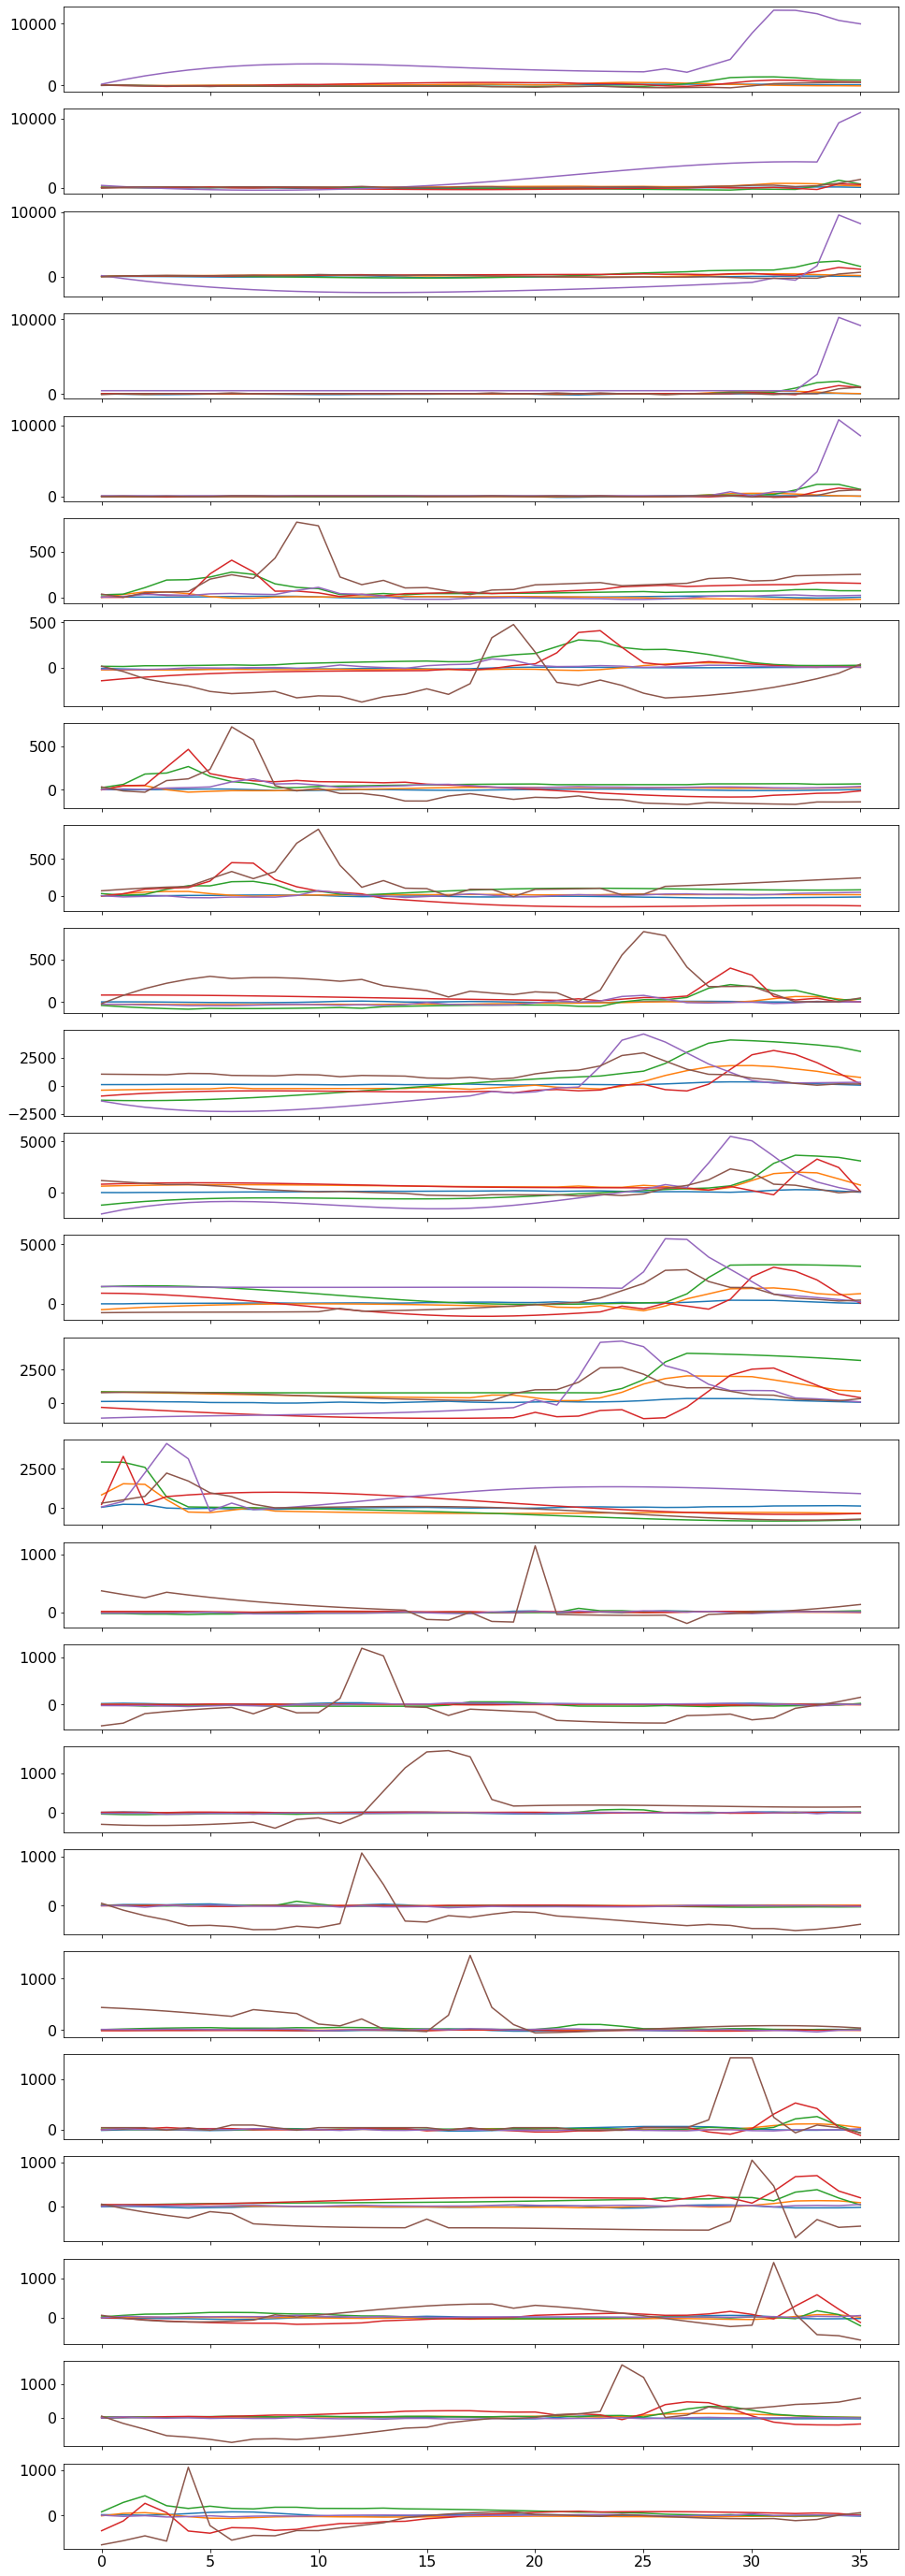

In [44]:
X_train_aug= my_augmenter.augment(x_train[0:5,:,:])
plot(X_train_aug)
np.shape(X_train_aug)

**2) ResNet**

In [45]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
tfk = tf.keras
tfkl = tf.keras.layers

In [46]:
def resnet50_model(input_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    lstm = tfkl.Bidirectional(tfkl.LSTM(512))(input_layer)
    dense_layer_1 = tfkl.Dense(3072, activation='relu')(lstm)
    dense_layer_2 = tfkl.Dense(3072, activation='relu')(dense_layer_1)
    Reshape = tfkl.Reshape((32, 32, 3), input_shape=(3072,))(dense_layer_2)
    model1 = tfk.Model(inputs=input_layer, outputs=Reshape, name='model')

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    GAP = layers.GlobalMaxPooling2D()
    flatten_layer = tf.keras.layers.Flatten()
    dropout = tf.keras.layers.Dropout(0.3)
    dense_layer_2 = layers.Dense(128, activation=None, kernel_initializer = tf.keras.initializers.HeUniform(seed))
    prediction_layer = layers.Dense(12, activation='softmax')
    batch_norm = layers.BatchNormalization()
    Relu = layers.ReLU()
    for layer in base_model.layers[0:]:
        layer.trainable = False
    model = Sequential([
    model1,
    base_model,
    #GAP,
    #flatten_layer,
    GAP,
    #dense_layer_3,
    #dropout,
    #dense_layer_1,
    #dropout,
    dense_layer_2,
    #batch_norm,
    Relu,
    dropout,
    prediction_layer
    ])
    #for layer in model.layers[2]:
    #    layer.trainable = False
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
model_ResNet50 = resnet50_model(input_shape)
model_ResNet50.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 32, 32, 3)         14714880  
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________

In [48]:
history = model_ResNet50.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        #tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001),
        tfk.callbacks.ModelCheckpoint('1res.hdf5', save_best_only=True, monitor='val_loss', mode='min'),
        #tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)

    ]
).history

Epoch 1/50
111/111 [==============================] - 12s 57ms/step - loss: 2.3063 - accuracy: 0.2780 - val_loss: 1.7953 - val_accuracy: 0.4315


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
111/111 [==============================] - 4s 37ms/step - loss: 1.6951 - accuracy: 0.4633 - val_loss: 1.4480 - val_accuracy: 0.5431
Epoch 3/50
111/111 [==============================] - 4s 37ms/step - loss: 1.3598 - accuracy: 0.5757 - val_loss: 1.3689 - val_accuracy: 0.5431
Epoch 4/50
111/111 [==============================] - 4s 38ms/step - loss: 1.1242 - accuracy: 0.6379 - val_loss: 1.2856 - val_accuracy: 0.5431
Epoch 5/50
111/111 [==============================] - 4s 37ms/step - loss: 0.9668 - accuracy: 0.6955 - val_loss: 1.2663 - val_accuracy: 0.6041
Epoch 6/50
111/111 [==============================] - 4s 37ms/step - loss: 0.8510 - accuracy: 0.7441 - val_loss: 1.2893 - val_accuracy: 0.5838
Epoch 7/50
111/111 [==============================] - 4s 39ms/step - loss: 0.7301 - accuracy: 0.7870 - val_loss: 1.3944 - val_accuracy: 0.5787
Epoch 8/50
111/111 [==============================] - 4s 38ms/step - loss: 0.6186 - accuracy: 0.8153 - val_loss: 1.6292 - val_accuracy: 0.5482

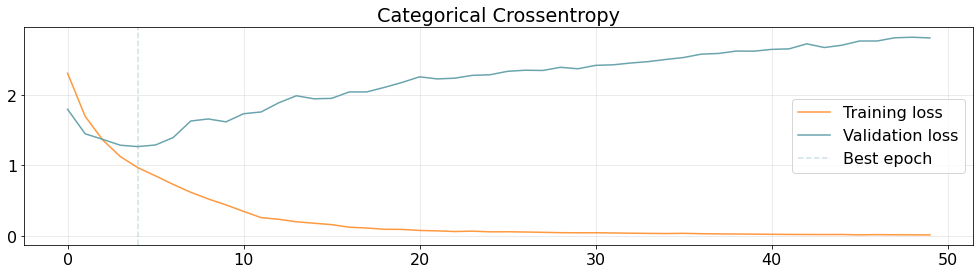

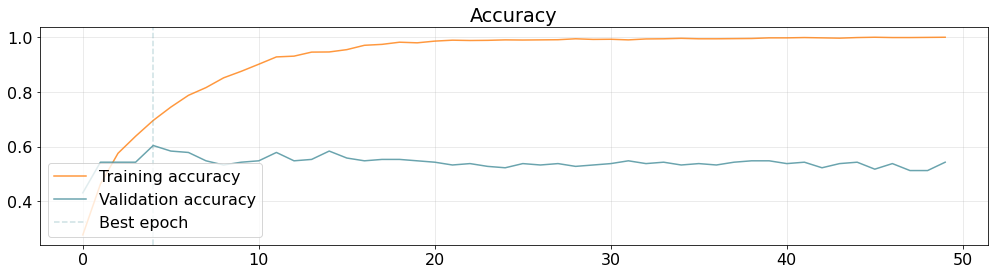

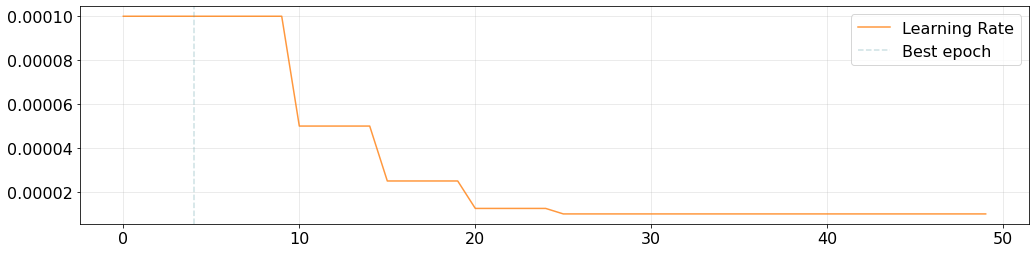

In [49]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

**3) Multi head Attention**

In [50]:
def build_ATT_classifier(input_shape, classes):
    input1 = tfkl.Input(shape=input_shape)

    multi_head1 = tfkl.MultiHeadAttention(num_heads=10,key_dim=1, name='Multi-Head1')(input1, input1, input1)


    flatt1 = tfkl.Flatten()(multi_head1)

    fully_connected = tfkl.Dense(100,activation='relu')(flatt1)

    hidden3 = tfkl.Dense(classes,activation='softmax')(fully_connected)

    model = tfk.Model(inputs=input1,outputs=hidden3)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

In [51]:
model_ATT = build_ATT_classifier(input_shape, classes)
model_ATT.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
Multi-Head1 (MultiHeadAttention (None, 36, 6)        276         input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 216)          0           Multi-Head1[0][0]                
______________________________________________________________________________________________

In [52]:
# Train the model
history_ATT = model_ATT.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/50
111/111 [==============================] - 1s 5ms/step - loss: 80.3776 - accuracy: 0.1672 - val_loss: 23.8295 - val_accuracy: 0.1371
Epoch 2/50
111/111 [==============================] - 0s 3ms/step - loss: 22.0406 - accuracy: 0.2209 - val_loss: 19.7982 - val_accuracy: 0.2284
Epoch 3/50
111/111 [==============================] - 0s 3ms/step - loss: 13.7523 - accuracy: 0.2746 - val_loss: 24.3855 - val_accuracy: 0.2589
Epoch 4/50
111/111 [==============================] - 0s 3ms/step - loss: 11.2561 - accuracy: 0.3090 - val_loss: 23.4479 - val_accuracy: 0.2843
Epoch 5/50
111/111 [==============================] - 0s 3ms/step - loss: 7.7281 - accuracy: 0.3463 - val_loss: 19.0445 - val_accuracy: 0.3046
Epoch 6/50
111/111 [==============================] - 0s 3ms/step - loss: 6.5804 - accuracy: 0.3559 - val_loss: 13.9485 - val_accuracy: 0.2995
Epoch 7/50
111/111 [==============================] - 0s 3ms/step - loss: 5.1010 - accuracy: 0.3910 - val_loss: 13.7020 - val_accuracy: 0.

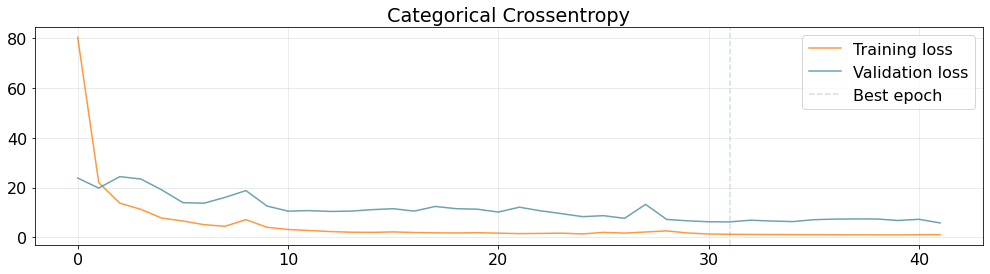

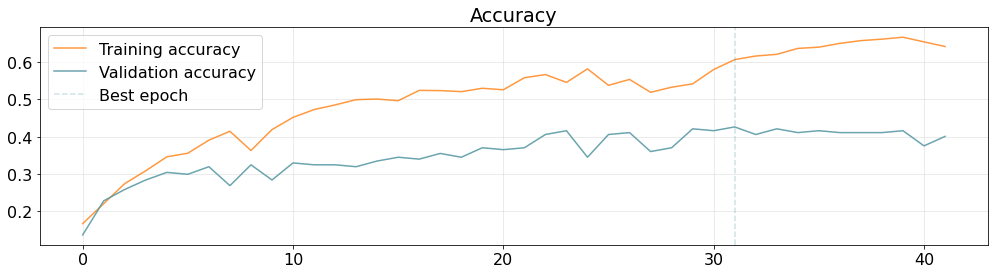

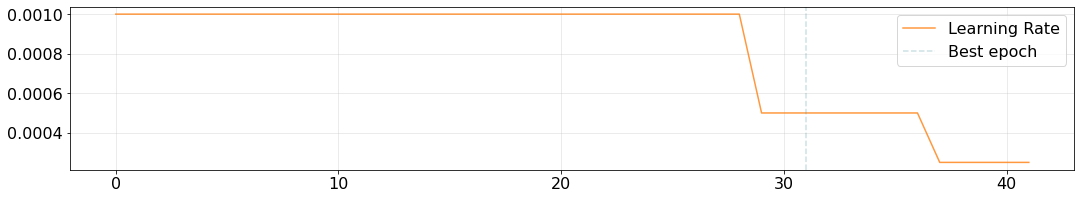

In [53]:
best_epoch = np.argmax(history_ATT['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history_ATT['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_ATT['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_ATT['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_ATT['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history_ATT['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [54]:
#model_ATT.save('ATT')

In [55]:
# Predict the test set with the BiLSTM
predictions_ATT = model_ATT.predict(X_test)
predictions_ATT.shape

(243, 12)

In [56]:
# Compute the confusion matrix
cm_ATT = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions_ATT, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ATT, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ATT, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ATT, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions_ATT, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print("Confusion Matrix:")
print(cm_ATT)

Accuracy: 0.4239
Precision: 0.365
Recall: 0.2717
F1: 0.2897
Confusion Matrix:
[[ 1  0  0  0  0  0  1  0  0  1  1  1]
 [ 0  4  1  2  0  0  2  0  1  3  0  0]
 [ 0  0 11  0  0  0  7  0  0  3  1  1]
 [ 0  0  1  7  0  4  1  0  0 21  0  2]
 [ 0  0  0  2  0  0  0  0  0  3  0  1]
 [ 0  0  3  2  0  1  0  0  0  8  0  0]
 [ 0  0  3  1  0  1  8  0  2 14  0  0]
 [ 0  0  1  1  0  2  0  2  1  4  0  1]
 [ 1  0  0  2  0  0  2  0  5  3  1  0]
 [ 2  0  0  7  0  1  2  1  0 61  2  1]
 [ 0  0  4  0  0  1  0  0  0  1  2  0]
 [ 0  0  0  1  0  0  1  1  0  2  0  1]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
